In [1]:
from io import open
import glob
import os
import unicodedata
import string
import pandas as pd
import random
random.seed(224)

In [2]:
def findFiles(path): 
    return glob.glob(path)

In [3]:
print(findFiles('surnames/names/*.txt'))

['surnames/names/Czech.txt', 'surnames/names/German.txt', 'surnames/names/Arabic.txt', 'surnames/names/Japanese.txt', 'surnames/names/Chinese.txt', 'surnames/names/Vietnamese.txt', 'surnames/names/Russian.txt', 'surnames/names/French.txt', 'surnames/names/Irish.txt', 'surnames/names/English.txt', 'surnames/names/Spanish.txt', 'surnames/names/Greek.txt', 'surnames/names/Italian.txt', 'surnames/names/Portuguese.txt', 'surnames/names/Scottish.txt', 'surnames/names/Dutch.txt', 'surnames/names/Korean.txt', 'surnames/names/Polish.txt']


In [4]:
all_letters = string.ascii_letters + " .,;'"
num_letters = len(all_letters)

In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' # "Mn" stands for Nonspacing_Mark, which is similar to unicodedata.combining 
        and c in all_letters
    )


#test 
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [6]:
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('surnames/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

num_categories = len(all_categories)

In [7]:
print(all_categories)

['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']


In [8]:
category_lines[all_categories[1]][:5] # first germany name

['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles']

In [9]:
num_names_percate = [len(category_lines[i]) for i in all_categories]

In [10]:
names_country = []
for n in [(str(i + ' ') * j).split() for i,j in zip(all_categories,num_names_percate)]:
    for m in n:
        names_country.append(m)
        
names = []
for n in [category_lines[i] for i in all_categories]:
    for m in n:
        names.append(m)

In [11]:
len_ = len(names)
trainp =.7
validp = 0.15
testp =0.15
split = ['train'] * int(len_*trainp) + ['valid'] * int(len_*validp) + ['test'] * (int(len_*testp)+1)
random.shuffle(split)

In [12]:
surname_df = pd.DataFrame(data = {'names':names,'names_country':names_country,'split':split})
surname_df.head()


,names,names_country,split
0,Abl,Czech,valid
1,Adsit,Czech,test
2,Ajdrna,Czech,train
3,Alt,Czech,train
4,Antonowitsch,Czech,valid


In [13]:
#surname_df.to_csv('surnames/surname.csv')

# Modeling --- Online learning

In [14]:
import torch #爸爸！！！爸爸你好


def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, num_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, num_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('X'))

print(lineToTensor('Alex').size()) # 5 charaters and, for each letter it should be 1 X 57 

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([4, 1, 57])


# Buidling RNN  from nn.Linear

In [15]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # concate the t-1 hidden with t input data
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(num_letters, n_hidden, num_categories)
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

## testing

In [16]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9805, -2.9533, -2.8982, -2.7936, -2.8423, -2.9583, -2.8443, -2.8792,
         -2.9536, -2.9280, -2.8742, -2.9232, -2.9661, -2.8080, -2.9657, -2.9130,
         -2.8037, -2.7796]], grad_fn=<LogSoftmaxBackward>)


In [17]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output)) # randomly initial outcome is Dutch.

('Polish', 17)


In [18]:
#We wont use batch at all, this is an online learning example
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [19]:
import torch.optim as optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(),lr= 0.01)

In [20]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):  # When didn't care about efficiency we dont have to pad our inputdata
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    optimizer.step()

    return output, loss.item()

In [21]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 2.3489 Pietsuh / Portuguese ✗ (Russian)
10000 10% (0m 24s) 0.2487 Filipowski / Polish ✓
15000 15% (0m 35s) 0.0749 Asahara / Japanese ✓
20000 20% (0m 47s) 3.6770 Eckstein / Scottish ✗ (German)
25000 25% (0m 57s) 0.7421 Madeira / Portuguese ✓
30000 30% (1m 9s) 0.6249 Paredes / Portuguese ✓
35000 35% (1m 21s) 0.5029 Wyrick / Polish ✓
40000 40% (1m 32s) 0.7028 Hoang / Vietnamese ✓
45000 45% (1m 44s) 2.6062 Santana / Italian ✗ (Portuguese)
50000 50% (1m 58s) 0.6566 Yee / Chinese ✓
55000 55% (2m 9s) 0.7682 Shamon / Arabic ✓
60000 60% (2m 19s) 0.7532 Koury / Arabic ✓
65000 65% (2m 31s) 3.2683 Olmos / Greek ✗ (Spanish)
70000 70% (2m 44s) 1.7293 Chlebek / Czech ✗ (Polish)
75000 75% (2m 56s) 0.0615 Vuong / Vietnamese ✓
80000 80% (3m 8s) 1.3579 Nunes / Portuguese ✓
85000 85% (3m 19s) 0.2351 Eoghan / Irish ✓
90000 90% (3m 30s) 2.3363 Fernandes / Dutch ✗ (Portuguese)
95000 95% (3m 40s) 0.5584 Murphy / Scottish ✓
100000 100% (3m 50s) 1.3822 Dubhain / Arabic ✗ (Irish)


In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

<Figure size 640x480 with 1 Axes>

# Evaluation

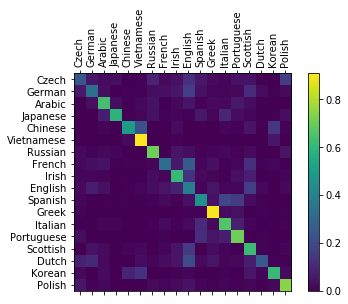

In [23]:
confusion = torch.zeros(num_categories, num_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    rnn.eval()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    #raw y , raw x , target, input
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(num_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [24]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

if __name__ == '__main__':
    predict('Dovesky')
    predict('Jackson')
    predict('Satoshi')


> Dovesky
(-0.67) Russian
(-1.47) Czech
(-2.28) English

> Jackson
(-0.54) Scottish
(-1.33) English
(-2.23) Russian

> Satoshi
(-0.57) Italian
(-2.39) Greek
(-2.58) Russian
